## A model build using TweetBERT to identify cause-effect pairs in sentences of tweets

The cause-effect pair sentence prediction model will be trained on the dataset which got augmented in an active learning approach in 5 steps.


In [45]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import transformers
from tqdm import tqdm, trange
from utils import normalizeTweet, split_into_sentences, bio_tagging, EarlyStopping
import matplotlib.pyplot as plt

########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



########################### DATA FILE ###################################
# dataPath = "/home/adrian/workspace/causality/Causal-associations-diabetes-twitter/data/Causality_tweets_data.xlsx"
dataPath = "data/Causality_tweets_data.xlsx"
#dataPath = "Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
lr = 1e-3    
adam_eps = 1e-8
epochs = 35
num_warmup_steps = 0
early_patience = 5 # how long to wait after last time validation loss improved

train_batch_size = 16
val_batch_size = 16
test_batch_size = 32
train_to_test_ratio = 0.9 # 10% test and 90% train
val_to_train_ratio = 0.2

metrics_average = "binary" # this will give measure for class_1,i.e., causal class

saveModelName = "./model-causal-model/NER_model_1_finetuned-{}-epochs-lr_{}.pth".format(epochs, lr) # it should be epoch so that the name shows at what epoch teh mdel ws saved

Cuda available:  False


In [25]:
##### DATA TO LOAD ######
data_round0 = pd.read_excel(dataPath, sheet_name="round0")
data_round0 = data_round0[data_round0["Causal association"].notnull()] # some tweets at the end are not labeled yet
data_round0 = data_round0[["full_text", "Intent", "Cause", "Effect", "Causal association"]]
print("Data round 0 (tweets!):")
print(data_round0["Causal association"].value_counts())
print("-----"*5)


##### additional data labeled through active learning strategy - round 1 ########
data_round1 = pd.read_excel(dataPath, sheet_name="round1")
data_round1 = data_round1[data_round1["Causal association"].notnull()]
data_round1 = data_round1[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round1.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("Sentences round 1:")
print(data_round1["Causal association"].value_counts())
print("-----"*5)

##### additional data labeled through active learning strategy - round 2 ########
data_round2 = pd.read_excel(dataPath, sheet_name="round2")
data_round2 = data_round2[data_round2["Causal association"].notnull()]
data_round2 = data_round2[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round2.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("sentences round 2:")
print(data_round2["Causal association"].value_counts())
print("-----"*5)

##### additional data labeled through active learning strategy - round 3 ########
data_round3 = pd.read_excel(dataPath, sheet_name="round3")
data_round3 = data_round3[data_round3["Causal association"].notnull()]
data_round3 = data_round3[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round3.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("sentences round 3:")
print(data_round3["Causal association"].value_counts())
print("-----"*5)

##### additional data labeled through active learning strategy - round 4 ########
data_round4 = pd.read_excel(dataPath, sheet_name="round4")
data_round4 = data_round4[data_round4["Causal association"].notnull()]
data_round4 = data_round4[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round4.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("sentences round 3:")
print(data_round3["Causal association"].value_counts())

#### merge both datasets ######
data = data_round0.append(data_round1).append(data_round2).append(data_round3).append(data_round4)
print("\nAfter merge old data:")
print(data["Causal association"].value_counts())
data.head()



Data round 0 (tweets!):
0.0    3710
1.0    1290
Name: Causal association, dtype: int64
-------------------------
Sentences round 1:
0.0    1763
1.0     429
Name: Causal association, dtype: int64
-------------------------
sentences round 2:
0    1658
1     150
Name: Causal association, dtype: int64
-------------------------
sentences round 3:
0    1886
1     215
Name: Causal association, dtype: int64
-------------------------
sentences round 3:
0    1886
1     215
Name: Causal association, dtype: int64

After merge old data:
0.0    10912
1.0     2397
Name: Causal association, dtype: int64


,full_text,Intent,Cause,Effect,Causal association
0,"tonight , I learned my older girl will back he...",NaN,NaN,NaN,0.0
1,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0.0
2,⬇ ️ ⬇ ️ ⬇ ️ THIS ⬇ ️ ⬇ ️ ⬇ ️ My wife has type ...,mS,NaN,NaN,0.0
3,USER Cheers ! Have one for this diabetic too !,mS,NaN,NaN,0.0
4,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0


## Preprocessing

In [28]:
################## add BIO tags and tokenized tweets ################

data["tokenized"] = data["full_text"].map(lambda tweet: normalizeTweet(tweet).split(" "))
data["bio_tags"] = data.apply(lambda row: bio_tagging(row["full_text"],row["Cause"], row["Effect"]), axis=1)
data.head(n=20)

,full_text,Intent,Cause,Effect,Causal association,tokenized,bio_tags
0,"tonight , I learned my older girl will back he...",NaN,NaN,NaN,0.0,"[tonight, ,, I, learned, my, older, girl, will...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0.0,"[USER, USER, I, knew, diabetes, and, fibromyal...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,⬇ ️ ⬇ ️ ⬇ ️ THIS ⬇ ️ ⬇ ️ ⬇ ️ My wife has type ...,mS,NaN,NaN,0.0,"[:down_arrow:, :down_arrow:, :down_arrow:, THI...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,USER Cheers ! Have one for this diabetic too !,mS,NaN,NaN,0.0,"[USER, Cheers, !, Have, one, for, this, diabet...","[O, O, O, O, O, O, O, O, O, O]"
4,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0,"[USER, Additionally, the, medicines, are, bein...","[O, O, O, B-C, I-C, I-C, I-C, I-C, I-C, O, O, ..."
5,USER USER We have those days Esp . if it inter...,msS,diabetic,hate,1.0,"[USER, USER, We, have, those, days, Esp, ., if...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6,Why all of a sudden are people hungry and vuln...,q,NaN,NaN,0.0,"[Why, all, of, a, sudden, are, people, hungry,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7,"i got lime for my glucose test , wasn't that b...",NaN,glucose test,nauseous,1.0,"[i, got, lime, for, my, glucose, test, ,, was,...","[O, O, O, O, O, B-C, I-C, O, O, O, O, O, O, O,..."
8,This stickur of Unkel Funny iz ware i am shave...,NaN,NaN,NaN,0.0,"[This, stickur, of, Unkel, Funny, iz, ware, i,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,For the second time in my life I gave myself i...,mS,NaN,NaN,0.0,"[For, the, second, time, in, my, life, I, gave...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [29]:
##### TEST to see on a random subsample which tokens get associated to which bio tag #######

#for i, row in data[data["Causal association"] == 1].sample(n=100).iterrows():
#    print()
#    print(row["Causal association"], "\tCause:",row["Cause"], "\tEffect:", row["Effect"])
#    for tok, tag in zip(row["tokenized"], row["bio_tags"]):
#        print(tok,tag)


1.0 	Cause: diabetes 	Effect: nonworking pancreas
i O
got O
this O
10 O
year O
diabetes B-C
medal O
in O
the O
mail O
for O
my O
10 O
year O
diaversary O
today O
so O
a O
big O
congratulations O
to O
me O
for O
living O
with O
a O
nonworking B-E
pancreas I-E
for O
half O
my O
life O
:p O
artying_face O
: O
:p O
artying_face O
: O
HTTPURL O

1.0 	Cause: blood pressure;diabetes 	Effect: stay at home
@USER O
My O
state O
is O
in O
a O
stay B-E
at I-E
home I-E
order O
, O
which O
I O
' O
m O
doing O
bc O
of O
my O
blood B-C
pressure I-C
/ O
diabetes B-C
but O
the O
rest O
of O
my O
city O
isn't O

1.0 	Cause: Carbohydrates;sugars 	Effect: diabetes
@USER O
Carbohydrates B-C
and O
sugars B-C
do O
cause O
diabetes B-E
if O
you O
do O
n't O
work O
out O
daily O
! O

1.0 	Cause: diabetes 	Effect: weight loss
Its O
like O
, O
weight B-E
loss I-E
due O
to O
acute O
diabetes B-C
. O

1.0 	Cause: diabetes 	Effect: legs were cut off;crying
@USER O
after O
my O
mom O
legs B-E
were I-E
cut I-E
off I-

go O
into O
feeling O
nerve O
impulses O
from O
their O
toes O
is O
redirected O
towards O
their O
studies O
. O
Synergy O
, O
HTTPURL O

1.0 	Cause: diabetic 	Effect: medication;insulin
USER O
My O
mum O
is O
diabetic B-C
I O
have O
been O
helping O
her O
with O
meals O
her O
medication B-E
and O
with O
her O
insulin B-E
its O
not O
easy O
but O
you O
will O
adjust O
in O
time O
Sierra O
your O
strong O
and O
you O
will O
get O
through O
this O
you O
will O
be O
ok O
hugz O
. O

1.0 	Cause: gestational diabetes 	Effect: worried
I O
' O
m O
worried B-E
I O
have O
gestational B-C
diabetes I-C
too O
: O
upside O
down_face O
: O

1.0 	Cause: #diabetes 	Effect: changing my habits
#diabetes B-C
is O
the O
worst O
and O
my O
#2018 O
#resolution O
is O
to O
get O
rid O
of O
it O
by O
changing B-E
my I-E
habits I-E
completely O
. O

1.0 	Cause: hypo;DKA 	Effect: dying
USER O
USER O
USER O
But O
I O
easily O
could O
have O
. O
Using O
an O
insulin O
with O
a O
curve O
you O
're O
not O
familiar

200 O
lbs O
. O
, O
pre B-C
diabetic I-C
, O
drinking O
and O
smoking O
too O
much O
, O
and O
she O
was O
only O
in O
her O
20 O
' O
s O
' O
It O
was O
n't O
until O
I O
joined O
a O
group O
setting O
and O
hired O
a O
coach O
and O
got O
some O
nutrition O
help O
that O
it O
actually O
became O
a O
lifestyle B-E
change I-E
for O
me O
, O
' O
" O
HTTPURL O

1.0 	Cause: can't afford insulin 	Effect: ration the very medicine
USER O
USER O
Tell O
that O
to O
the O
people O
they O
can't B-C
afford I-C
insulin I-C
. O
You O
dumb O
fuck O
. O
It O
's O
a O
disgrace O
in O
this O
country O
where O
human O
beings O
have O
to O
ration B-E
the I-E
very I-E
medicine I-E
that O
's O
needed O
to O
keep O
them O
alive O
. O
From O
2015 O
! O
It O
's O
2019 O
, O
now O
same O
shit O
. O
HTTPURL O

1.0 	Cause: #T1D;#T2D 	Effect: serve in the military
You O
know O
what O
? O
People O
who O
are O
#T1D B-C
or O
#T2D B-C
can't O
serve B-E
in I-E
the I-E
military I-E
. O
Where O
's O
the O
outrage O
for O

In [30]:
def get_start_end_index_of_sentence_in_tweet(tweet, sentence):
    """ 
    The sentence tokens are included in the tweet tokens.
    Return the start end end indices of the sentence tokens in the tweet tokens

    """

    sentence_start_word = sentence[0]
    start_indices = [i for i, x in enumerate(tweet) if x == sentence_start_word] # find all indices of the start word of the sentence 
    try:
        for start_index in start_indices:
            isTrueStartIndex = all([tweet[start_index+i] == sentence[i] for i in range(len(sentence))])
            #print("start_index:", start_index, "isTrueStartIndex:", isTrueStartIndex)
            if isTrueStartIndex:
                return start_index, start_index + len(sentence) 
    except:
        print("ERROR: StartIndex should have been found for sentence:")
        print("tweet:")
        print(tweet)
        print("sentence:")
        print(sentence)
    return -1, -2 # should not be returned


def split_tweets_to_sentences(data):
    """ 
        Splits tweets into sentences and associates the appropriate intent, causes, effects and causal association
        to each sentence.
        
        Parameters:
        - min_words_in_sentences: Minimal number of words in a sentence such that the sentence is kept. 
                                  Assumption: A sentence with too few words does not have enough information
                              
                              
                              
        Ex.:
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what? type 1 causes insulin dependence | q;msS  | type 1|insulin dependence | 1       | ...  
        
        New dataframe returned: 
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what?                                  |   q    |       |        |       0            | ...
        type 1 causes insulin dependence       |        | type 1| insulin dependence | 1       | ...  
    """

    newDF = pd.DataFrame(columns=["sentence", "Intent", "Cause", "Effect", "Causal association", "tokenized", "bio_tags"])
    
    for i,row in data.iterrows():
        causes = row["Cause"]
        effects = row["Effect"]
        sentences = split_into_sentences(normalizeTweet(row["full_text"]))
        
        # single sentence in tweet
        if len(sentences) == 1:
            singleSentenceIntent = ""
            if isinstance(row["Intent"], str):
                if len(row["Intent"].split(";")) > 1:
                    singleSentenceIntent = row["Intent"].strip().replace(";msS", "").replace("msS;", "").replace(";mS", "").replace("mS;", "")
                else:
                    if row["Intent"] == "mS" or row["Intent"] == "msS":
                        singleSentenceIntent = ""
                    else:
                        singleSentenceIntent = row["Intent"].strip()
                    
            newDF=newDF.append(pd.Series({"sentence": sentences[0] # only one sentence
                         , "Intent": singleSentenceIntent
                         , "Cause" : row["Cause"]
                         , "Effect": row["Effect"]
                         , "Causal association" : row["Causal association"]
                         , "tokenized": row["tokenized"]
                         , "bio_tags": row["bio_tags"]}), ignore_index=True)
        
        # tweet has several sentences
        else: 
            intents = str(row["Intent"]).strip().split(";")
            for sentence in sentences:
                sent_tokenized = sentence.split(" ")
                causeInSentence = np.nan if not isinstance(causes, str) or not any([cause in sentence for cause in causes.split(";")]) else ";".join([cause for cause in causes.split(";") if cause in sentence])
                effectInSentence = np.nan if not isinstance(effects, str) or not any([effect in sentence for effect in effects.split(";")]) else ";".join([effect for effect in effects.split(";") if effect in sentence])
                causalAssociationInSentence = 1 if isinstance(causeInSentence, str) and isinstance(effectInSentence, str) else 0
                startIndex, endIndex = get_start_end_index_of_sentence_in_tweet(row["tokenized"], sent_tokenized)
                sentence_tokenized = row["tokenized"][startIndex:endIndex]
                sentence_bio_tags = row["bio_tags"][startIndex:endIndex]
                
                if "q" in intents and sentence[-1] == "?": # if current sentence is question
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "q", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized, "bio_tags": sentence_bio_tags}), ignore_index=True)                    
                elif "joke" in intents: # all sentences with "joke" in tweet keep the intent "joke"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "joke", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized, "bio_tags": sentence_bio_tags}), ignore_index=True)   
                elif "neg" in intents: # all sentences with "neg" in tweet keep intent "neg"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "neg", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized, "bio_tags": sentence_bio_tags}), ignore_index=True)               
                elif isinstance(causeInSentence, str) and isinstance(effectInSentence, str): # cause effect sentence
                    causalIntent = ""
                    if len(causeInSentence.split(";")) > 1:
                        causalIntent = "mC"
                        if len(effectInSentence.split(";")) > 1:
                            causalIntent = "mC;mE"
                    elif len(effectInSentence.split(";")) > 1:
                        causalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": causalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized, "bio_tags": sentence_bio_tags}), ignore_index=True)                                  
                else:
                    nonCausalIntent = ""
                    if isinstance(causeInSentence, str): # only cause is given
                        if len(causeInSentence.split(";")) > 1:
                            nonCausalIntent = "mC"
                    elif isinstance(effectInSentence, str): # only effect is given
                        if len(effectInSentence.split(";")) > 1:
                            nonCausalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": nonCausalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized, "bio_tags": sentence_bio_tags}), ignore_index=True)

    return newDF
       

In [31]:
### Split tweets into sentences (train classifier on sentence level) ####

print("N tweets:", data.shape[0])
dataSentences = split_tweets_to_sentences(data)
print("N sentences:", dataSentences.shape[0])
dataSentences.head()

N tweets: 13309
N sentences: 20065


,sentence,Intent,Cause,Effect,Causal association,tokenized,bio_tags
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,Fiercely .,,NaN,NaN,0,"[Fiercely, .]","[O, O]"
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]","[O, O, O, O]"
3,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0,"[USER, USER, I, knew, diabetes, and, fibromyal...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,:face_with_rolling_eyes:,joke,NaN,NaN,0,[:face_with_rolling_eyes:],[O]


In [32]:
########## Remove sentences with joke, question, negation and keep only sentences with more than 3 tokens #####

print("N sentences before filtering: ", dataSentences.shape[0])
dataSentFiltered = dataSentences[~dataSentences["Intent"].str.contains("neg|joke|q")] # remove sentences with joke, q, neg
dataSentFiltered = dataSentFiltered[dataSentFiltered["tokenized"].map(len) >= 3] # only keep sentences with at least 3 words
print("N sentences after filtering: ", dataSentFiltered.shape[0])
dataSentFiltered.head()


N sentences before filtering:  20065
N sentences after filtering:  16868


,sentence,Intent,Cause,Effect,Causal association,tokenized,bio_tags
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]","[O, O, O, O]"
5,:down_arrow: :down_arrow: :down_arrow: THIS :d...,,NaN,NaN,0,"[:down_arrow:, :down_arrow:, :down_arrow:, THI...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
6,I 'm a trans woman .,,NaN,NaN,0,"[I, 'm, a, trans, woman, .]","[O, O, O, O, O, O]"
7,"Both of us could use a world where "" brave and...",,NaN,NaN,0,"[Both, of, us, could, use, a, world, where, "",...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [35]:
############ Choose causal tweets to train on ##################

# choose sentences with cause and effect
#trainingData = dataSentFiltered[dataSentFiltered["Causal association"] == 1]

# choose sentences with cause or effect
trainingData = dataSentFiltered[(dataSentFiltered["Cause"].notnull()) | (dataSentFiltered["Effect"].notnull())]

trainingData.shape

(2500, 7)

### Training

In [36]:
trainingDataSample = trainingData#.sample(n=200)   # VIVEK: DELETE TAKING SAMPLE. THIS WAS ONLY FOR TESTING
train = trainingDataSample.sample(frac=train_to_test_ratio, random_state=0)
test = trainingDataSample.drop(train.index)
validate = train.sample(frac=val_to_train_ratio, random_state=0)
train = train.drop(validate.index)
print("Train:", train.shape)
print("Validate:", validate.shape)
print("Test:", test.shape)

Train: (144, 7)
Validate: (36, 7)
Test: (20, 7)


In [37]:
# Transform labels + encodings into Pytorch DataSet object (including __len__, __getitem__)
class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, bio_tags, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.bio_tags = bio_tags
        self.tag2id = {label: idx for idx, label in enumerate(["O", "B-C", "I-C", "B-E", "I-E"])}
        self.tag2id[-100] = -100
        self.id2tag = {id:tag for tag,id in self.tag2id.items()}

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        bio_tags_extended = self.extend_tags(self.text[idx], self.bio_tags[idx], ids[idx])
        assert(len(ids[idx]) == len(bio_tags_extended), "token ids and BIO tags lengths do not match!")
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
              , "bio_tags" : torch.tensor(list(map(lambda bioTags: self.tag2id[bioTags], bio_tags_extended))
, dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

    
    def extend_tags(self, tokens_old, tags_old, ids_tokenized_padded):
        """ 
            Each token has a BIO tag label. 
            However BERT's tokenization splits tokens into subwords. How to label those subwords?
            
            Option 1:
            ---------
            
            add the same label to each subword than the first subword. Only replace "B" by "I"
            Ex. 
            #lowbloodsugar => '#low@@', 'blood@@', 'sugar@@'
               "B-C"       =>   "B-C" ,   "I-C"  ,   "I-C"
            
            Option 2 (implemented):      
            ---------
            
            From : https://huggingface.co/transformers/custom_datasets.html#token-classification-with-w-nut-emerging-entities
            A common obstacle with using pre-trained models for token-level classification: many of the tokens in
            the W-NUT corpus are not in DistilBert’s vocabulary. Bert and many models like it use a method called 
            WordPiece Tokenization, meaning that single words are split into multiple tokens such that each token
            is likely to be in the vocabulary. For example, DistilBert’s tokenizer would split the Twitter 
            handle @huggingface into the tokens ['@', 'hugging', '##face']. This is a problem for us because we 
            have exactly one tag per token. If the tokenizer splits a token into multiple sub-tokens, then we will
            end up with a mismatch between our tokens and our labels.

            One way to handle this is to only train on the tag labels for the first subtoken of a split token. 
            We can do this in 🤗 Transformers by setting the labels we wish to ignore to -100. 
            In the example above, if the label for @HuggingFace is 3 (indexing B-corporation), we would set 
            the labels of ['@', 'hugging', '##face'] to [3, -100, -100].
        """
        tags = [-100] # add for start token <CLS>
        for token_old, tag in zip(tokens_old.split(" "), tags_old):
#            print(F"\ntoken_old: {token_old};    tag: {tag}")
            for i, sub_token in enumerate(self.tokenizer.tokenize(token_old)):
                if (i == 0):
                    tags.append(tag)
                else: 
                    tags.append(-100)
           
        tags.append(-100) # 0 for end of sentence token
    
        # append -100 for all padded elements
        padded_elements = ids_tokenized_padded.count(1) # id 1 is <PAD> ; Alternative: where attention_mask == 0 add -100
        tags.extend([-100]*padded_elements)
        
        return tags
        
        
    
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

train_dataset = TweetDataSet(train["sentence"].values.tolist()
                           , train["Causal association"].values.tolist()
                           , train["bio_tags"].values.tolist()
                           , tokenizer)
val_dataset = TweetDataSet(validate["sentence"].values.tolist()
                           , validate["Causal association"].values.tolist()
                           , validate["bio_tags"].values.tolist()
                           , tokenizer)
test_dataset = TweetDataSet(test["sentence"].values.tolist()
                           , test["Causal association"].values.tolist()
                           , test["bio_tags"].values.tolist()
                           , tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# put data to batches
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)


<>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-37-0c37bf1cd15e>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(ids[idx]) == len(bio_tags_extended), "token ids and BIO tags lengths do not match!")
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


144
36
20


In [38]:
############ class weights #####################

# Since -100 will anyway be ignored by loss func, drop it
#train_bio_tags = np.hstack([t["bio_tags"][t["bio_tags"]!=-100].numpy() for t in train_dataset])
#print("train_bio_tags:", train_bio_tags)

#train_bio_tags_count_info = (pd.Series(train_bio_tags).value_counts(normalize=True))
#print("train_bio_tags_count_info:", train_bio_tags_count_info)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_bio_tags_count_info obtained above has fraction of 
# samples for ith class, hence the corresponding weight calculation is:
#class_weight = (1/train_bio_tags_count_info)/len(train_bio_tags_count_info)
#class_weight = class_weight[sorted(class_weight.index)]
#class_weight

### Evaluation Metrics

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred, labels):
    """
        Dataset is unbalanced -> measure weighted metrics
        Calculate metrics for each label, and find their average wieghted by support (Number of true instances for each label)
        This alters 'macro' to account for label imbalance;
        it can result in an F-Score taht is not between precision and recall
    """
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='macro') # TODO: check weightin
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


### Model definition

In [40]:
class CausalNER(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalNER, self).__init__()
        self.num_labels = 5 # B-C, I-C, B-E, I-E, O
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, self.num_labels)
        self.softmax = torch.nn.Softmax(-1)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
#        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token
        output_seq, _ = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token
        output_2 = self.dropout(output_seq)
        output_3 = self.linear1(output_2)
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5 # 5


In [46]:
model = CausalNER()
model.to(device)

# fine-tune only the task-specific parameters 
for param in model.bert.parameters():
    param.requires_grad = False
#     param[:-1].requires_grad = False
#     param[-1].requires_grad = True

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
# scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0;
# after a warmup period during which it increases linearly from to the initial lr set in the optimizer
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) 


## adding weight to the loss function 
#loss_fn = CrossEntropyLoss(
#    weight=torch.tensor(class_weight.to_list()).to(device),
#    ignore_index=-100 # ignore subwords/tokens with label -100 
#)

loss_fn = CrossEntropyLoss(ignore_index=-100)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['lm_head.dense.weight', 'roberta.encoder.layer.6.attention.output.LayerNorm.bias', 'roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.intermediate.dense.bias', 'roberta.encoder.layer.11.attention.self.key.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.6.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.3.attention.self.value.weight', 'roberta.encoder.layer.7.attention.self.key.weight', 'roberta.embeddings.position_ids', 'roberta.encoder.layer.11.intermediate.dense.bias', 'roberta.encoder.layer.3.intermediate.dense.weight', 'roberta.encoder.layer.11.attention.output.LayerNorm.weight', 'roberta.encoder.layer.

Some weights of BertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['encoder.layer.2.attention.output.LayerNorm.bias', 'encoder.layer.3.output.dense.bias', 'encoder.layer.2.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.3.attention.self.key.weight', 'encoder.layer.1.attention.self.query.bias', 'encoder.layer.5.attention.self.value.bias', 'encoder.layer.11.attention.output.LayerNorm.weight', 'encoder.layer.8.attention.self.key.bias', 'encoder.layer.2.attention.self.value.bias', 'encoder.layer.9.attention.self.value.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.9.output.dense.bias', 'encoder.layer.7.output.LayerNorm.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.5.output.dense.bias', 'encoder.layer.11.attention.self.key.weight', 'encoder.layer.7.attention.self.value.weight', 'enc

In [47]:
################ TRAINING ######################

# initialise the early_stopping object
early_stopping = EarlyStopping(patience=early_patience, path=saveModelName, verbose=True)

train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0

N_bio_tags = 5 # "O", "B-C", "I-C", "B-E", "I-C"
for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")

    
    ############ training eval metrics ######################
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    #########################################################
    
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        bio_tags = batch['bio_tags'].to(device)
        
        ################################################
        model.train() # set model to training mode
        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass

        ################################################ 
        # similar to the class RobertaForToken classification in transformers: https://github.com/huggingface/transformers/blob/master/src/transformers/models/roberta/modeling_roberta.py
        active_loss = attention_mask.view(-1) == 1  # either based on attention_mask (includes <CLS>, <SEP> token)
        active_logits = logits.view(-1, N_bio_tags)[active_loss] # N_bio_tags=5 
        active_tags = bio_tags.view(-1)[active_loss]
        loss = loss_fn(active_logits, active_tags)             
        print("loss:", loss)       ## TODO VIVEK: check loss function calculation
        loss.backward() # backward pass
        optim.step()    # update parameters and take a steup using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
            
            
        ################## Training Performance Measures ##########
        logits = logits.detach().to('cpu').numpy()
        tags_ids = bio_tags.to('cpu').numpy()

        # calculate performance measures only on tokens and not subwords or special tokens
        tags_mask = tags_ids != -100 # only get token labels and not labels from subwords or special tokens
        pred = np.argmax(logits, axis=2)[tags_mask] #.flatten() # convert logits to list of predicted labels
        tags = tags_ids[tags_mask]                      
                
        metrics = compute_metrics(pred, tags)
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
                          
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))           
    print(F'\n\tTraining Loss: {np.mean(train_loss)}')
    print(F'\n\tTraining acc: {np.mean(train_acc)}')
    print(F'\n\tTraining prec: {np.mean(train_prec)}')
    print(F'\n\tTraining rec: {np.mean(train_rec)}')
    print(F'\n\tTraining f1: {np.mean(train_f1)}')

    n_trained_epochs += 1

                          
    ###################################################################################

    
    ## ---- Validation ------    
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []

    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        v_input_ids, v_input_mask, v_token_type_ids, v_labels, v_bio_tags = batch  # unpack inputs from dataloader
        
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            model.eval() # put model in evaluation mode for validation set
            logits = model(**{"input_ids":v_input_ids, "attention_mask":v_input_mask, "token_type_ids":v_token_type_ids}) # forward pass, calculates logit predictions

        ######################################################
        
        # similar to the class RobertaForToken classification in transformers: https://github.com/huggingface/transformers/blob/master/src/transformers/models/roberta/modeling_roberta.py
        v_active_loss = v_input_mask.view(-1) == 1  # either based on attention_mask (includes <CLS>, <SEP> token)
        v_active_logits = logits.view(-1, N_bio_tags)[v_active_loss] # 5 
        v_active_tags = v_bio_tags.view(-1)[v_active_loss]
        v_loss = loss_fn(v_active_logits, v_active_tags)             
        val_loss.append(v_loss.item())
              
        #########################################################
        logits = logits.detach().to('cpu').numpy()
        tags_ids = v_bio_tags.to('cpu').numpy()

        # calculate performance measures only on tokens and not subwords or special tokens
        tags_mask = tags_ids != -100 # only get token labels and not labels from subwords or special tokens
        pred = np.argmax(logits, axis=2)[tags_mask] #.flatten() # convert logits to list of predicted labels
        tags = tags_ids[tags_mask]#.flatten()        
        
        metrics = compute_metrics(pred, tags)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])
                              
    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))        
    print(F'\n\tValidation Loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 1 ======================>



 11%|█         | 1/9 [00:02<00:16,  2.09s/it]

loss: tensor(1.6030, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:14,  2.02s/it]

loss: tensor(0.7684, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:12,  2.06s/it]

loss: tensor(1.2215, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:09,  1.99s/it]

loss: tensor(1.5748, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:09<00:07,  1.94s/it]

loss: tensor(1.1240, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:11<00:05,  1.92s/it]

loss: tensor(1.2572, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:13<00:03,  1.92s/it]

loss: tensor(0.6651, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:15<00:01,  1.98s/it]

loss: tensor(0.8978, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:17<00:00,  1.99s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.8215, grad_fn=<NllLossBackward>)

	Training Loss: 1.1036964058876038

	Training acc: 0.74323449945535

	Training prec: 0.16414053388977626

	Training rec: 0.19710282019270783

	Training f1: 0.1721705069820663


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.58it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.7599676966667175

	Validation acc: 0.8280154566770553

	Validation prec: 0.16560309133541104

	Validation rec: 0.2

	Validation f1: 0.18110621313534278
Validation loss decreased (inf --> 0.759968).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 2 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:16,  2.06s/it]

loss: tensor(0.9301, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:14,  2.01s/it]

loss: tensor(0.9470, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:05<00:11,  1.97s/it]

loss: tensor(0.7993, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:10,  2.03s/it]

loss: tensor(0.7743, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:10<00:08,  2.08s/it]

loss: tensor(0.7993, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:12<00:06,  2.08s/it]

loss: tensor(0.6511, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:14<00:04,  2.09s/it]

loss: tensor(0.8675, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:16<00:02,  2.10s/it]

loss: tensor(0.7195, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:18<00:00,  2.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.8396, grad_fn=<NllLossBackward>)

	Training Loss: 0.8141728308465745

	Training acc: 0.8097038260421141

	Training prec: 0.19928374685228492

	Training rec: 0.20298766387646677

	Training f1: 0.18574475330268547


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.60it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.7813913702964783

	Validation acc: 0.8253962004571761

	Validation prec: 0.1650792400914352

	Validation rec: 0.2

	Validation f1: 0.18080926425408408
EarlyStopping counter: 1 out of 5
<====================== Epoch 3 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:19,  2.41s/it]

loss: tensor(0.6431, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:16,  2.41s/it]

loss: tensor(0.7204, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:07<00:14,  2.40s/it]

loss: tensor(0.8463, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:09<00:12,  2.49s/it]

loss: tensor(0.7077, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:12<00:09,  2.39s/it]

loss: tensor(0.6342, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:14<00:06,  2.28s/it]

loss: tensor(0.7092, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:16<00:04,  2.21s/it]

loss: tensor(0.8184, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:18<00:02,  2.18s/it]

loss: tensor(0.6826, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:20<00:00,  2.27s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.7177, grad_fn=<NllLossBackward>)

	Training Loss: 0.7199553383721246

	Training acc: 0.8158818210836979

	Training prec: 0.26879314593006787

	Training rec: 0.20871200864011322

	Training f1: 0.19535326617660698


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.68it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6212101221084595

	Validation acc: 0.8381059191019983

	Validation prec: 0.31415609912142994

	Validation rec: 0.24434920634920632

	Validation f1: 0.2500183573368344
Validation loss decreased (0.759968 --> 0.621210).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 4 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:17,  2.13s/it]

loss: tensor(0.7461, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:14,  2.10s/it]

loss: tensor(0.6754, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:12,  2.09s/it]

loss: tensor(0.6750, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:10,  2.08s/it]

loss: tensor(0.7502, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:10<00:08,  2.07s/it]

loss: tensor(0.7939, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:12<00:06,  2.09s/it]

loss: tensor(0.5774, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:14<00:04,  2.09s/it]

loss: tensor(0.6474, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

loss: tensor(0.5274, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:18<00:00,  2.09s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.7990, grad_fn=<NllLossBackward>)

	Training Loss: 0.6879892150561014

	Training acc: 0.8180477755923595

	Training prec: 0.3519983192914614

	Training rec: 0.22314090628460725

	Training f1: 0.21984193586416947


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.71it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6974098205566406

	Validation acc: 0.8129652440181608

	Validation prec: 0.16259304880363218

	Validation rec: 0.2

	Validation f1: 0.1792292583404262
EarlyStopping counter: 1 out of 5
<====================== Epoch 5 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:17,  2.15s/it]

loss: tensor(0.8218, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:15,  2.22s/it]

loss: tensor(0.7359, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:13,  2.17s/it]

loss: tensor(0.7060, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:10,  2.13s/it]

loss: tensor(0.7607, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:10<00:08,  2.11s/it]

loss: tensor(0.7009, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:12<00:06,  2.10s/it]

loss: tensor(0.5534, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:14<00:04,  2.12s/it]

loss: tensor(0.5709, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:17<00:02,  2.12s/it]

loss: tensor(0.5358, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:19<00:00,  2.21s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.7341, grad_fn=<NllLossBackward>)

	Training Loss: 0.6799490650494894

	Training acc: 0.817340486295262

	Training prec: 0.3201999891059484

	Training rec: 0.22681013351185644

	Training f1: 0.22413560136924537


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:01<00:04,  1.01s/it]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6354132056236267

	Validation acc: 0.8384676714762118

	Validation prec: 0.3395987273565641

	Validation rec: 0.2647792207792208

	Validation f1: 0.27476498230126334
EarlyStopping counter: 2 out of 5
<====================== Epoch 6 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:19,  2.48s/it]

loss: tensor(0.6978, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:16,  2.42s/it]

loss: tensor(0.6175, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:13,  2.29s/it]

loss: tensor(0.7670, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:09<00:10,  2.19s/it]

loss: tensor(0.5673, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:11<00:08,  2.15s/it]

loss: tensor(0.5826, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:13<00:06,  2.14s/it]

loss: tensor(0.5408, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:15<00:04,  2.14s/it]

loss: tensor(0.8425, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:17<00:02,  2.13s/it]

loss: tensor(0.6178, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:19<00:00,  2.17s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.7182, grad_fn=<NllLossBackward>)

	Training Loss: 0.661276810699039

	Training acc: 0.8155763178076632

	Training prec: 0.30226004336830414

	Training rec: 0.21981466912170192

	Training f1: 0.2138719842321216


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.62it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6810721933841706

	Validation acc: 0.8211213348055454

	Validation prec: 0.3040355964029907

	Validation rec: 0.23985329485329485

	Validation f1: 0.24171780559833986
EarlyStopping counter: 3 out of 5
<====================== Epoch 7 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:16,  2.06s/it]

loss: tensor(0.7796, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:14,  2.08s/it]

loss: tensor(0.6367, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:07<00:15,  2.53s/it]

loss: tensor(0.6741, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:09<00:12,  2.56s/it]

loss: tensor(0.5095, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:12<00:11,  2.76s/it]

loss: tensor(0.7250, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:15<00:07,  2.53s/it]

loss: tensor(0.6644, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:17<00:04,  2.40s/it]

loss: tensor(0.6775, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:19<00:02,  2.31s/it]

loss: tensor(0.5582, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:21<00:00,  2.37s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.6381, grad_fn=<NllLossBackward>)

	Training Loss: 0.6514470444785224

	Training acc: 0.8212770556663916

	Training prec: 0.38135057008800066

	Training rec: 0.24262273798371295

	Training f1: 0.2490263299723886


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.70it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6558398365974426

	Validation acc: 0.8355226864713456

	Validation prec: 0.3402900551104118

	Validation rec: 0.27795704948646127

	Validation f1: 0.28823648284755166
EarlyStopping counter: 4 out of 5
<====================== Epoch 8 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:16,  2.05s/it]

loss: tensor(0.6100, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:14,  2.07s/it]

loss: tensor(0.6735, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:12,  2.08s/it]

loss: tensor(0.6004, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:10,  2.10s/it]

loss: tensor(0.6969, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:11<00:09,  2.31s/it]

loss: tensor(0.6301, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:13<00:06,  2.25s/it]

loss: tensor(0.5632, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:15<00:04,  2.21s/it]

loss: tensor(0.6919, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:17<00:02,  2.17s/it]

loss: tensor(0.6232, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:19<00:00,  2.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.6277, grad_fn=<NllLossBackward>)

	Training Loss: 0.6352099710040622

	Training acc: 0.8203375619763442

	Training prec: 0.34167640662181376

	Training rec: 0.2354125133557685

	Training f1: 0.23552892076977935


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.62it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6126009821891785

	Validation acc: 0.8381051815968018

	Validation prec: 0.34480411068068684

	Validation rec: 0.2778438228438228

	Validation f1: 0.2865630506463065
Validation loss decreased (0.621210 --> 0.612601).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 9 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:17,  2.21s/it]

loss: tensor(0.4838, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:16,  2.33s/it]

loss: tensor(0.6835, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:14,  2.34s/it]

loss: tensor(0.5901, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:09<00:11,  2.24s/it]

loss: tensor(0.5960, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:11<00:08,  2.21s/it]

loss: tensor(0.6351, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:13<00:06,  2.31s/it]

loss: tensor(0.6023, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:16<00:04,  2.31s/it]

loss: tensor(0.6363, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:19<00:02,  2.61s/it]

loss: tensor(0.7264, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:21<00:00,  2.40s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.6732, grad_fn=<NllLossBackward>)

	Training Loss: 0.6251904004149966

	Training acc: 0.8223379839034539

	Training prec: 0.3472172264373701

	Training rec: 0.25035083909201516

	Training f1: 0.256312428794539


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.44it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6095851957798004

	Validation acc: 0.8409110028925084

	Validation prec: 0.3434687360539495

	Validation rec: 0.27722555222555223

	Validation f1: 0.28543852123379676
Validation loss decreased (0.612601 --> 0.609585).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 10 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:17,  2.20s/it]

loss: tensor(0.6458, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 2/9 [00:04<00:15,  2.23s/it]

loss: tensor(0.6638, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:13,  2.18s/it]

loss: tensor(0.4598, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:11,  2.26s/it]

loss: tensor(0.6032, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 5/9 [00:11<00:08,  2.19s/it]

loss: tensor(0.5880, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:13<00:06,  2.16s/it]

loss: tensor(0.6697, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:15<00:04,  2.14s/it]

loss: tensor(0.7245, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:17<00:02,  2.11s/it]

loss: tensor(0.6168, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:19<00:00,  2.16s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.7482, grad_fn=<NllLossBackward>)

	Training Loss: 0.6355342037147946

	Training acc: 0.8231951412441001

	Training prec: 0.4400999168031082

	Training rec: 0.2741195041764026

	Training f1: 0.2872152956724686


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.69it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6227314591407775

	Validation acc: 0.8372354953203585

	Validation prec: 0.33829779805044236

	Validation rec: 0.2708641436339144

	Validation f1: 0.28153106121082117
EarlyStopping counter: 1 out of 5
<====================== Epoch 11 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:16,  2.08s/it]

loss: tensor(0.6320, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:14,  2.07s/it]

loss: tensor(0.5589, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:12,  2.09s/it]

loss: tensor(0.6636, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:10,  2.08s/it]

loss: tensor(0.7222, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 5/9 [00:10<00:08,  2.09s/it]

loss: tensor(0.5128, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:12<00:06,  2.08s/it]

loss: tensor(0.5315, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:14<00:04,  2.10s/it]

loss: tensor(0.6545, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:17<00:02,  2.33s/it]

loss: tensor(0.6336, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:20<00:00,  2.28s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.6485, grad_fn=<NllLossBackward>)

	Training Loss: 0.617510113451216

	Training acc: 0.8223767578364043

	Training prec: 0.4374502297744175

	Training rec: 0.2553146377476081

	Training f1: 0.2676546137832843


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.65it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.593219769001007

	Validation acc: 0.8457911206174906

	Validation prec: 0.32946730677947944

	Validation rec: 0.27050061050061047

	Validation f1: 0.27540024787781736
Validation loss decreased (0.609585 --> 0.593220).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 12 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:17,  2.22s/it]

loss: tensor(0.5792, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:14,  2.13s/it]

loss: tensor(0.5906, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:12,  2.14s/it]

loss: tensor(0.5242, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:10,  2.12s/it]

loss: tensor(0.4769, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:11<00:09,  2.44s/it]

loss: tensor(0.6769, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:13<00:06,  2.32s/it]

loss: tensor(0.4614, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:15<00:04,  2.23s/it]

loss: tensor(0.8651, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:17<00:02,  2.26s/it]

loss: tensor(0.7415, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:20<00:00,  2.23s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.6771, grad_fn=<NllLossBackward>)

	Training Loss: 0.6214331554041969

	Training acc: 0.8245530768530064

	Training prec: 0.3919822793516624

	Training rec: 0.2651558576526984

	Training f1: 0.2783843319871137


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.71it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6063868403434753

	Validation acc: 0.8359776504577532

	Validation prec: 0.3394990493499683

	Validation rec: 0.27720678353709205

	Validation f1: 0.2878806926568213
EarlyStopping counter: 1 out of 5
<====================== Epoch 13 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:16,  2.10s/it]

loss: tensor(0.6175, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:16,  2.36s/it]

loss: tensor(0.5981, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 3/9 [00:07<00:14,  2.40s/it]

loss: tensor(0.6001, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:10<00:13,  2.66s/it]

loss: tensor(0.5884, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:12<00:10,  2.66s/it]

loss: tensor(0.6141, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:14<00:07,  2.47s/it]

loss: tensor(0.6453, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:17<00:04,  2.35s/it]

loss: tensor(0.5979, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:19<00:02,  2.26s/it]

loss: tensor(0.6959, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:21<00:00,  2.35s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.7016, grad_fn=<NllLossBackward>)

	Training Loss: 0.6287577152252197

	Training acc: 0.8243803242201695

	Training prec: 0.40246200044077723

	Training rec: 0.2635520250362251

	Training f1: 0.2772402335219576


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.72it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6013965129852294

	Validation acc: 0.8431432101522287

	Validation prec: 0.33931523610112313

	Validation rec: 0.2756186741363212

	Validation f1: 0.2863908854088691
EarlyStopping counter: 2 out of 5
<====================== Epoch 14 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:17,  2.19s/it]

loss: tensor(0.5943, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:15,  2.16s/it]

loss: tensor(0.5470, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:12,  2.11s/it]

loss: tensor(0.8021, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:10,  2.09s/it]

loss: tensor(0.6590, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:10<00:08,  2.11s/it]

loss: tensor(0.6420, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 6/9 [00:12<00:06,  2.12s/it]

loss: tensor(0.5176, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:14<00:04,  2.12s/it]

loss: tensor(0.6391, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:16<00:02,  2.10s/it]

loss: tensor(0.5864, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:18<00:00,  2.11s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.6209, grad_fn=<NllLossBackward>)

	Training Loss: 0.6231516202290853

	Training acc: 0.8276625711956889

	Training prec: 0.40707764903763705

	Training rec: 0.27873565662226263

	Training f1: 0.291166898691271


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.69it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.6127000033855439

	Validation acc: 0.8351682204212925

	Validation prec: 0.36572316445604114

	Validation rec: 0.2963120307188104

	Validation f1: 0.3064520631611397
EarlyStopping counter: 3 out of 5
<====================== Epoch 15 ======================>


/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 1/9 [00:02<00:16,  2.06s/it]

loss: tensor(0.5874, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 2/9 [00:04<00:14,  2.07s/it]

loss: tensor(0.6703, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:12,  2.08s/it]

loss: tensor(0.6888, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:10,  2.07s/it]

loss: tensor(0.6211, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:10<00:08,  2.08s/it]

loss: tensor(0.4123, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:12<00:06,  2.10s/it]

loss: tensor(0.6151, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 7/9 [00:14<00:04,  2.08s/it]

loss: tensor(0.6976, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:16<00:02,  2.14s/it]

loss: tensor(0.6782, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:18<00:00,  2.10s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.6269, grad_fn=<NllLossBackward>)

	Training Loss: 0.6219541993406084

	Training acc: 0.8244135648530737

	Training prec: 0.4707685683396953

	Training rec: 0.2616269409761668

	Training f1: 0.27765517926060385


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.66it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.5972902119159699

	Validation acc: 0.8427558400255537

	Validation prec: 0.3124668019248848

	Validation rec: 0.2639370807309739

	Validation f1: 0.269847700467839
EarlyStopping counter: 4 out of 5
<====================== Epoch 16 ======================>



 11%|█         | 1/9 [00:02<00:16,  2.05s/it]

loss: tensor(0.7300, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 2/9 [00:04<00:14,  2.06s/it]

loss: tensor(0.5493, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 3/9 [00:06<00:12,  2.09s/it]

loss: tensor(0.6284, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 4/9 [00:08<00:10,  2.10s/it]

loss: tensor(0.5887, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 5/9 [00:10<00:08,  2.10s/it]

loss: tensor(0.6644, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 6/9 [00:12<00:06,  2.09s/it]

loss: tensor(0.5781, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 7/9 [00:14<00:04,  2.09s/it]

loss: tensor(0.5114, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 8/9 [00:16<00:02,  2.08s/it]

loss: tensor(0.5806, grad_fn=<NllLossBackward>)


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 9/9 [00:18<00:00,  2.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

loss: tensor(0.6424, grad_fn=<NllLossBackward>)

	Training Loss: 0.6081567075517442

	Training acc: 0.8241855168288457

	Training prec: 0.45358854487809086

	Training rec: 0.27258851104779136

	Training f1: 0.29084296241460533


<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 1/5 [00:00<00:02,  1.57it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation Loss: 0.5947404026985168

	Validation acc: 0.843725302412263

	Validation prec: 0.3156694554496031

	Validation rec: 0.26662031356509885

	Validation f1: 0.27378850269644095
EarlyStopping counter: 5 out of 5
Early stopping


In [48]:
print(n_trained_epochs)
print(train_avg_loss)
print(val_avg_loss)

16
[1.1036964058876038, 0.8141728308465745, 0.7199553383721246, 0.6879892150561014, 0.6799490650494894, 0.661276810699039, 0.6514470444785224, 0.6352099710040622, 0.6251904004149966, 0.6355342037147946, 0.617510113451216, 0.6214331554041969, 0.6287577152252197, 0.6231516202290853, 0.6219541993406084, 0.6081567075517442]
[0.7599676966667175, 0.7813913702964783, 0.6212101221084595, 0.6974098205566406, 0.6354132056236267, 0.6810721933841706, 0.6558398365974426, 0.6126009821891785, 0.6095851957798004, 0.6227314591407775, 0.593219769001007, 0.6063868403434753, 0.6013965129852294, 0.6127000033855439, 0.5972902119159699, 0.5947404026985168]


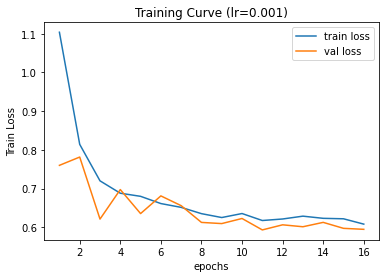

In [49]:
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

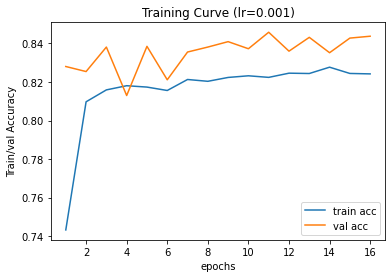

In [50]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train/val Accuracy")
plt.legend(loc="best")
plt.show()

In [ ]:
########### save model ###########
# torch.save(model.state_dict(), "finetuned-35-epochs-1e3-lr-with-weighted-loss.pth") # early stopping saves model

### Evaluation on the test dataset

In [51]:

############ test eval metrics ######################
test_true_labels = []
test_predict_labels = []
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []

########################################################
for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    t_input_ids, t_input_mask, t_token_type_ids, t_labels, t_bio_tags = batch     # unpack inputs from dataloader

    with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
        model.eval() # put model in evaluation mode for validation set
        logits = model(**{"input_ids":t_input_ids, "attention_mask":t_input_mask, "token_type_ids":t_token_type_ids}) # forward pass, calculates logit predictions

    ######################################################

    # similar to the class RobertaForToken classification in transformers: https://github.com/huggingface/transformers/blob/master/src/transformers/models/roberta/modeling_roberta.py
    t_active_loss = t_input_mask.view(-1) == 1  # either based on attention_mask (includes <CLS>, <SEP> token)
    t_active_logits = logits.view(-1, N_bio_tags)[t_active_loss] # 5 
    t_active_tags = t_bio_tags.view(-1)[t_active_loss]
    t_loss = loss_fn(t_active_logits, t_active_tags)             
    test_loss.append(t_loss.item())

    #########################################################
    logits = logits.detach().to('cpu').numpy()
    tags_ids = t_bio_tags.to('cpu').numpy()

    # calculate performance measures only on tokens and not subwords or special tokens
    tags_mask = tags_ids != -100 # only get token labels and not labels from subwords or special tokens
    pred = np.argmax(logits, axis=2)[tags_mask] #.flatten() # convert logits to list of predicted labels
    tags = tags_ids[tags_mask]#.flatten()                          
    test_true_labels.append(tags) # appends true labels for batch
    test_predict_labels.append(pred) # # appends predicted labels for batch
    
    metrics = compute_metrics(pred, tags)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])


print(F'\n\tTest Loss: {np.mean(test_loss)}')
print(F'\n\tTest acc: {np.mean(test_acc)}')
print(F'\n\tTest prec: {np.mean(test_prec)}')
print(F'\n\tTest rec: {np.mean(test_rec)}')
print(F'\n\tTest f1: {np.mean(test_f1)}')


  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 33%|███▎      | 1/3 [00:00<00:01,  1.77it/s]<ipython-input-37-0c37bf1cd15e>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorc


	Test Loss: 0.7512330611546835

	Test acc: 0.7968859747296598

	Test prec: 0.19587309882580328

	Test rec: 0.21666666666666667

	Test f1: 0.20149843260188086


### Classification reports

In [52]:
from sklearn.metrics import classification_report
tag2id = {label: idx for idx, label in enumerate(["O", "B-C", "I-C", "B-E", "I-E"])}
tag2id[-100] = -100
id2tag = {id:tag for tag,id in tag2id.items()}
test_true_tag = [id2tag[ID] for ID in np.concatenate(test_true_labels)]#
test_predict_tag = [id2tag[ID] for ID in np.concatenate(test_predict_labels)]
print(classification_report(test_true_tag, test_predict_tag))


              precision    recall  f1-score   support

         B-C       0.12      0.04      0.06        23
         B-E       0.00      0.00      0.00        21
         I-C       0.00      0.00      0.00        22
         I-E       0.00      0.00      0.00        18
           O       0.81      1.00      0.89       311

    accuracy                           0.79       395
   macro avg       0.19      0.21      0.19       395
weighted avg       0.64      0.79      0.71       395



/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [53]:
from seqeval.metrics import classification_report as classification_report_seqeval

#The metrics we are seeing in this report are designed specifically for NLP tasks such as NER and POS tagging,
#in which all words of an entity need to be predicted correctly to be counted as one correct prediction. 
#Therefore, the metrics in this classification report are much lower than in scikit-learn's classification report.
test_true_tag = [[id2tag[ID] for ID in IDS] for IDS in test_true_labels]
test_predict_tag = [[id2tag[ID] for ID in IDS] for IDS in test_predict_labels]
print(classification_report_seqeval(test_true_tag, test_predict_tag))

              precision    recall  f1-score   support

           C       0.12      0.04      0.06        23
           E       1.00      0.05      0.09        21

   micro avg       0.22      0.05      0.08        44
   macro avg       0.56      0.05      0.08        44
weighted avg       0.54      0.05      0.08        44



### bio tags back to tokens

In [27]:
# take last batch of test set:
t_input_ids, t_input_mask, t_token_type_ids, t_labels, t_bio_tags = batch 

for i in range(len(batch)):
    tags_mask = t_bio_tags[i].to("cpu").numpy() != -100 # only get token labels and not labels from subwords or special tokens
    pred = np.argmax(logits[i], axis=1)[tags_mask]
    true_tags = t_bio_tags[i][tags_mask].to("cpu").numpy()    
    

    tokens = tokenizer.convert_ids_to_tokens(t_input_ids[i])

    print("\n\nPadded Sentence:")
    print(tokens)
    print("true labels:")
    print(t_bio_tags[i])
    for token, true_label, pred in zip(np.array(tokens)[tags_mask], true_tags, pred):
        print(token, "\t\ttrue:", true_label, "  pred:", pred)

    
    break






Padded Sentence:
['<s>', 'USER', 'I', 'am', 'considered', 'high', 'risk', 'because', 'I', 'have', 'type', '2', 'diabetes', ',', 'but', 'I', 'do', 'have', 'a', 'strong', 'immune', 'system', ';', 'rarely', 'get', 'sick', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
true labels:
tensor([-100,    0,    0,    0,    0,    3,    4,    0,    0,    0,    1,    2,
           2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,

### Save model

In [28]:
torch.save(model.state_dict(), "weighted-loss-moreData.pth")

### Load model locally

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CausalNER()
model.load_state_dict(torch.load("weighted-loss-moreData.pth"))
model.to(device)
model.eval()

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.10.intermediate.dense.weight', 'lm_head.decoder.bias', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'roberta.encoder.layer.0.intermediate.dense.weight', 'roberta.encoder.layer.3.attention.self.key.bias', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.5.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.self.key.weight', 'roberta.encoder.layer.8.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.value.bias', 'roberta.encoder.layer.9.output.dense.weight', 'roberta.encoder.layer.11.attention.output.dense.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.5.attention.output.LayerNorm.weight', 'roberta.encoder.layer

CausalNER(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  

In [30]:
# dir(TweetDataSet)

In [36]:
from transformers import BertTokenizer

In [38]:
tokenizer1 = AutoTokenizer.from_pretrained("vinai/bertweet-base")
tokenizer2 = AutoTokenizer.from_pretrained("roberta-base")
tokenizer3 = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer4 = BertTokenizer.from_pretrained("bert-base-uncased")
#bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
seq = normalizeTweet("#diabetes is a shitty disease")


print(tokenizer1.tokenize(seq))
print(tokenizer2.tokenize(seq))
print(tokenizer3.tokenize(seq))
print(tokenizer4.tokenize(seq))




Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['#@@', 'diabetes', 'is', 'a', 'shitty', 'disease']
['#', 'di', 'abetes', 'Ġis', 'Ġa', 'Ġshitty', 'Ġdisease']
['#', 'diabetes', 'is', 'a', 'shit', '##ty', 'disease']
['#', 'diabetes', 'is', 'a', 'shitty', 'disease']


In [41]:
for i, row in data[1:10].iterrows():
    print(tokenizer1.tokenize(row["full_text"]))
    print(tokenizer2.tokenize(row["full_text"]))
    print(tokenizer4.tokenize(row["full_text"]))
    print()

['USER', 'USER', 'I', 'knew', 'diabetes', 'and', 'fi@@', 'bro@@', 'my@@', 'al@@', 'gia', 'were', 'all', 'big', 'fake', 'conditions', 'just', 'like', 'cancer', '.', '🙄']
['USER', 'ĠUS', 'ER', 'ĠI', 'Ġknew', 'Ġdiabetes', 'Ġand', 'Ġfib', 'romy', 'algia', 'Ġwere', 'Ġall', 'Ġbig', 'Ġfake', 'Ġconditions', 'Ġjust', 'Ġlike', 'Ġcancer', 'Ġ.', 'ĠðŁ', 'Ļ', 'Ħ']
['user', 'user', 'i', 'knew', 'diabetes', 'and', 'fi', '##bro', '##my', '##al', '##gia', 'were', 'all', 'big', 'fake', 'conditions', 'just', 'like', 'cancer', '.', '[UNK]']

['⬇', '️', '⬇', '️', '⬇', '️', 'THIS', '⬇', '️', '⬇', '️', '⬇', '️', 'My', 'wife', 'has', 'type', '-', '1', 'diabetes', '.', 'I@@', "'m", 'a', 'trans', 'woman', '.', 'Both', 'of', 'us', 'could', 'use', 'a', 'world', 'where', '"', 'brave', 'and', 'strong', '"', 'runs', 'a', 'distant', 'second', 'to', '"', 'comfortable', 'and', 'included', '"', '.', 'Make', 'a', 'world', 'where', 'people', 'can', 'just', 'be', ',', 'without', 'having', 'to', 'be', '"', 'brave', 'and', 's